# Exact solution used in MES runs


We would like to MES the operation (in a cylindrical geometry)

$$
J\nabla \cdot \left(S_n\frac{\nabla_\perp \phi}{B}\right)
$$

As we have a homogenenous $B$-field, we have normalized it out, and remain with

$$
J\nabla \cdot \left(S_n\nabla_\perp \phi\right)
$$

In [1]:
%matplotlib notebook

from sympy import init_printing
from sympy import S
from sympy import sin, cos, tanh, exp, pi, sqrt

from boutdata.mms import x, y, z, t
from boutdata.mms import Delp2, DDX, DDY, DDZ

import os, sys
# If we add to sys.path, then it must be an absolute path
common_dir = os.path.abspath('./../../../')
# Sys path is a list of system paths
sys.path.append(common_dir)
from common.python.mesGenerator import get_metric, make_plot, BOUT_print

init_printing()

## Initialize

In [2]:
folder = '../twoGaussians/'
metric = get_metric()

## Define the variables

In [3]:
# Initialization
the_vars = {}

### Define manifactured solutions

We have that

$$JS = J\nabla\cdot(S_n\nabla_\perp\phi) = JS_n\nabla_\perp^2\phi + J\nabla S_n\cdot \nabla_\perp \phi = JS_n\nabla_\perp^2\phi + J\nabla_\perp S_n\cdot \nabla_\perp \phi$$

We will use the `Delp2` operator for the perpendicular Laplace operator (as the y-derivatives vanishes in cylinder geometry). We have

`Delp2`$(f)=g^{xx}\partial_x^2 f + g^{zz}\partial_z^2 f + 2g^{xz}\partial_x\partial_z f + G^1\partial_x f + G^3\partial_z f$

Using the cylinder geometry, we get that

`Delp2`$(f)=\partial_x^2 f + \frac{1}{x^2}\partial_z^2 f + \frac{1}{x}\partial_x f$

Further on, due to orthogonality we have that
$$\nabla_\perp S_n\cdot \nabla_\perp \phi = \mathbf{e}^i\cdot \mathbf{e}^i(\partial_i S_n)(\partial_i \phi)
 = g^{xx}(\partial_x S_n)(\partial_x \phi) + g^{zz}(\partial_z S_n)(\partial_z \phi) = (\partial_x S_n)(\partial_x \phi) + \frac{1}{x^2}(\partial_z S_n)(\partial_z \phi)$$

This gives

$$JS = \nabla\cdot(S_n\nabla_\perp\phi) = xS_n\partial_x^2 \phi + S_n\frac{1}{x}\partial_z^2 \phi + S_n\partial_x \phi + (\partial_x S_n)(\partial_x \phi) + \frac{1}{x}(\partial_z S_n)(\partial_z \phi)$$

We will use this to calculate the analytical solution.

**NOTE**:

1. z must be periodic
2. z must be of class infinity in $0$ and $2\pi$
3. x must be of class infinity in $0$
4. The field $f(\rho, \theta)$ must be continuous in the $\rho$ direction with $f(\rho, \theta + \pi)$
5. Eventual BC in $\rho$ must be satisfied

In [4]:
# We need Lx
from boututils.options import BOUTOptions
myOpts = BOUTOptions(folder)
Lx = eval(myOpts.geom['Lx'])

In [5]:
# Two normal gaussians

# The gaussian
# In cartesian coordinates we would like
# f = exp(-(1/(2*w^2))*((x-x0)^2 + (y-y0)^2))
# In cylindrical coordinates, this translates to
# f = exp(-(1/(2*w^2))*(x^2 + y^2 + x0^2 + y0^2 - 2*(x*x0+y*y0) ))
#   = exp(-(1/(2*w^2))*(rho^2 + rho0^2 - 2*rho*rho0*(cos(theta)*cos(theta0)+sin(theta)*sin(theta0)) ))
#   = exp(-(1/(2*w^2))*(rho^2 + rho0^2 - 2*rho*rho0*(cos(theta - theta0)) ))

w = 0.8*Lx
rho0 = 0.3*Lx
theta0 = 5*pi/4
the_vars['phi'] = exp(-(1/(2*w**2))*(x**2 + rho0**2 - 2*x*rho0*(cos(z - theta0)) ))

w = 0.5*Lx
rho0 = 0.2*Lx
theta0 = 0
the_vars['S_n'] = exp(-(1/(2*w**2))*(x**2 + rho0**2 - 2*x*rho0*(cos(z - theta0)) ))

Calculate the solution

In [6]:
the_vars['S'] = metric.J*(  the_vars['S_n']*Delp2(the_vars['phi'], metric=metric)\
                          + metric.g11*DDX(the_vars['S_n'], metric=metric)*DDX(the_vars['phi'], metric=metric)\
                          + metric.g33*DDZ(the_vars['S_n'], metric=metric)*DDZ(the_vars['phi'], metric=metric)\
                          )

## Plot

<IPython.core.display.Javascript object>


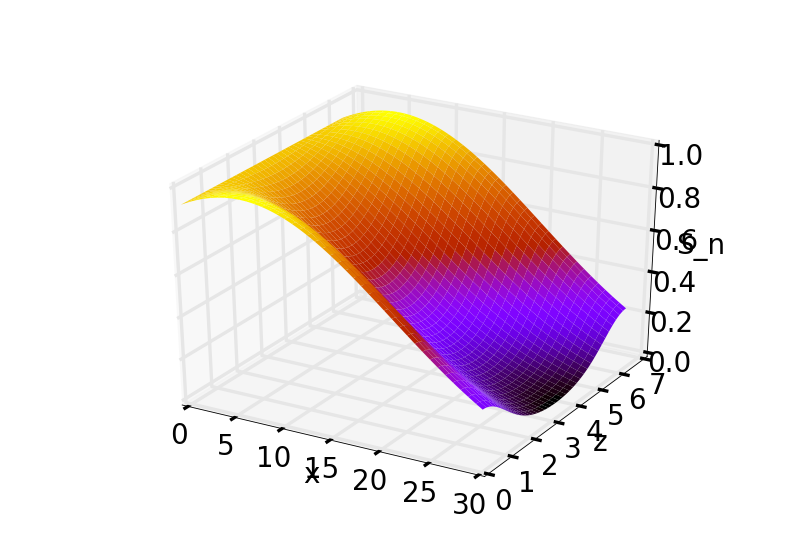

<IPython.core.display.Javascript object>


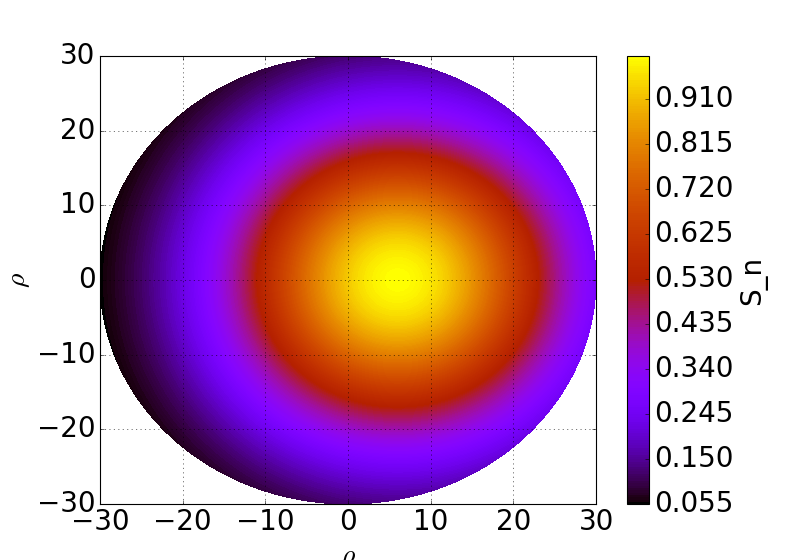

<IPython.core.display.Javascript object>


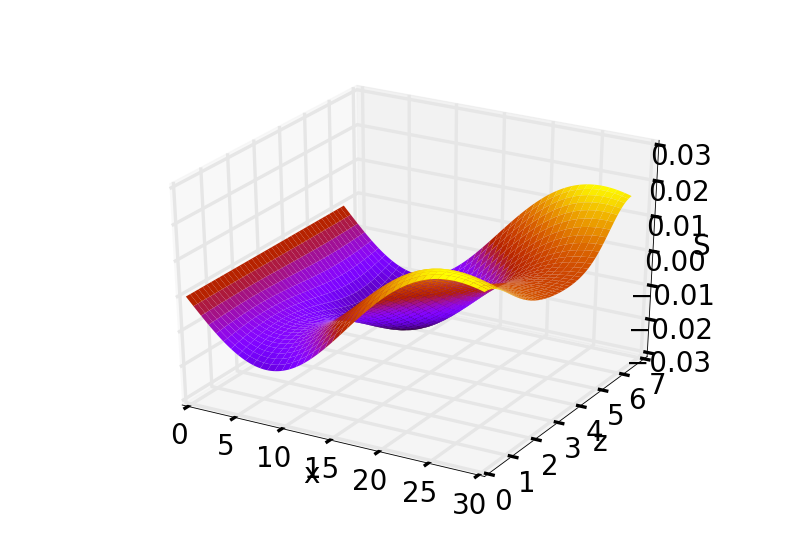

<IPython.core.display.Javascript object>


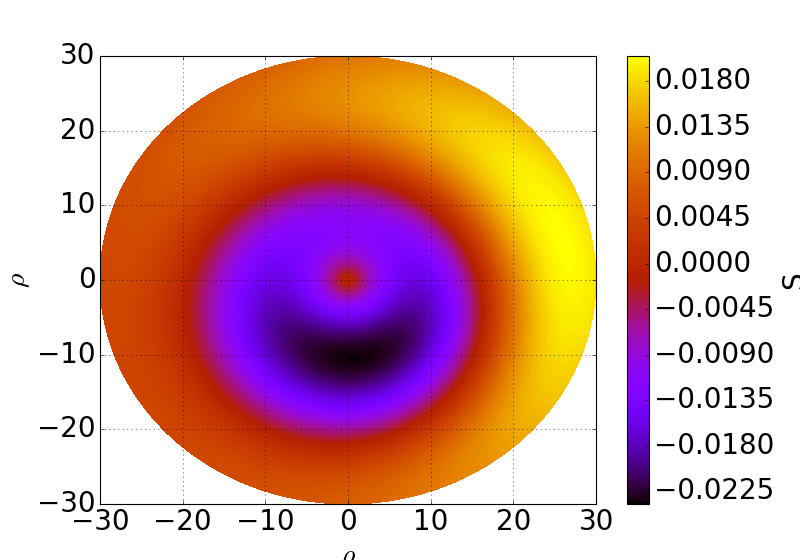

<IPython.core.display.Javascript object>


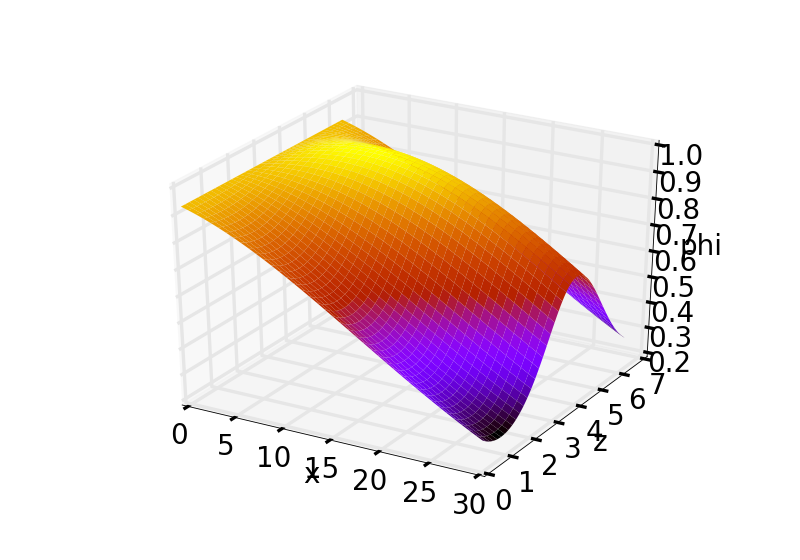

<IPython.core.display.Javascript object>


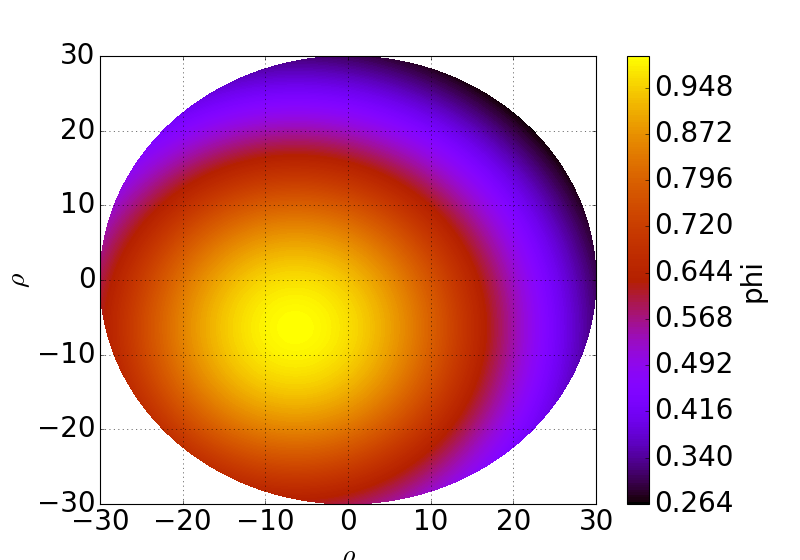

In [7]:
make_plot(folder=folder, the_vars=the_vars, plot2d=True, include_aux=False)

## Print the variables in BOUT++ format

In [8]:
BOUT_print(the_vars, rational=False)


[S_n]
0.923116346386636*exp(-0.00222222222222222*geom:xl^2 + 0.0266666666666667*geom:xl*cos(z))

[S]
geom:xl*(0.860439047204804*(-0.00444444444444444*geom:xl + 0.0266666666666667*cos(z))*(-0.00173611111111111*geom:xl - 0.015625*sin(z + pi/4))*exp(-0.00222222222222222*geom:xl^2 + 0.0266666666666667*geom:xl*cos(z))*exp(-0.000868055555555556*geom:xl^2 - 0.015625*geom:xl*sin(z + pi/4)) + 0.923116346386636*((0.932102492359528*(0.00173611111111111*geom:xl + 0.015625*sin(z + pi/4))^2 - 0.00161823349367974)*exp(-geom:xl*(0.000868055555555556*geom:xl + 0.015625*sin(z + pi/4))) + 0.932102492359528*(-0.00173611111111111*geom:xl - 0.015625*sin(z + pi/4))*exp(-0.000868055555555556*geom:xl^2 - 0.015625*geom:xl*sin(z + pi/4))/geom:xl + (0.000227564085048713*geom:xl*cos(z + pi/4)^2 + 0.0145641014431176*sin(z + pi/4))*exp(-geom:xl*(0.000868055555555556*geom:xl + 0.015625*sin(z + pi/4)))/geom:xl)*exp(-0.00222222222222222*geom:xl^2 + 0.0266666666666667*geom:xl*cos(z)) + 0.000358516269668668*exp(-0.00222